In [2]:
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [31]:
import yfinance as yf
ticker='GAZP.ME'
# Get the data for the stock AAPL
data = yf.download(ticker,'2018-01-01','2021-07-05')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-03,131.029999,132.199997,130.630005,132.199997,102.487640,10534020
2018-01-04,132.500000,136.199997,132.300003,135.889999,105.348297,32096520
2018-01-05,135.600006,137.119995,135.080002,137.119995,106.301857,19981260
2018-01-09,138.000000,141.350006,137.600006,140.000000,108.534569,52493450
2018-01-10,140.490005,143.429993,139.580002,143.429993,111.193657,51773300
...,...,...,...,...,...,...
2021-06-28,277.220001,279.609985,276.899994,277.480011,265.651306,25641510
2021-06-29,276.119995,277.500000,273.170013,276.070007,264.301392,36361820
2021-06-30,277.269989,281.769989,276.500000,281.170013,269.183990,58505740


In [32]:
df=pd.DataFrame(data['Adj Close'],index=data.index)
df=df.rename(columns={"Adj Close":"close"})

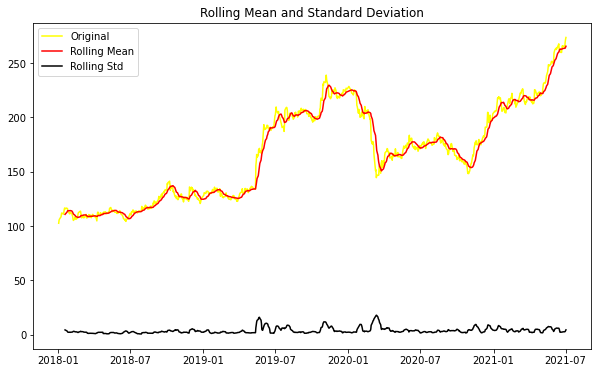

Results of dickey fuller test
Test Statistics                 -0.069277
p-value                          0.952414
No. of lags used                 1.000000
Number of observations used    875.000000
critical value (1%)             -3.437846
critical value (5%)             -2.864849
critical value (10%)            -2.568532
dtype: float64


In [33]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['close'])

<Figure size 720x432 with 0 Axes>

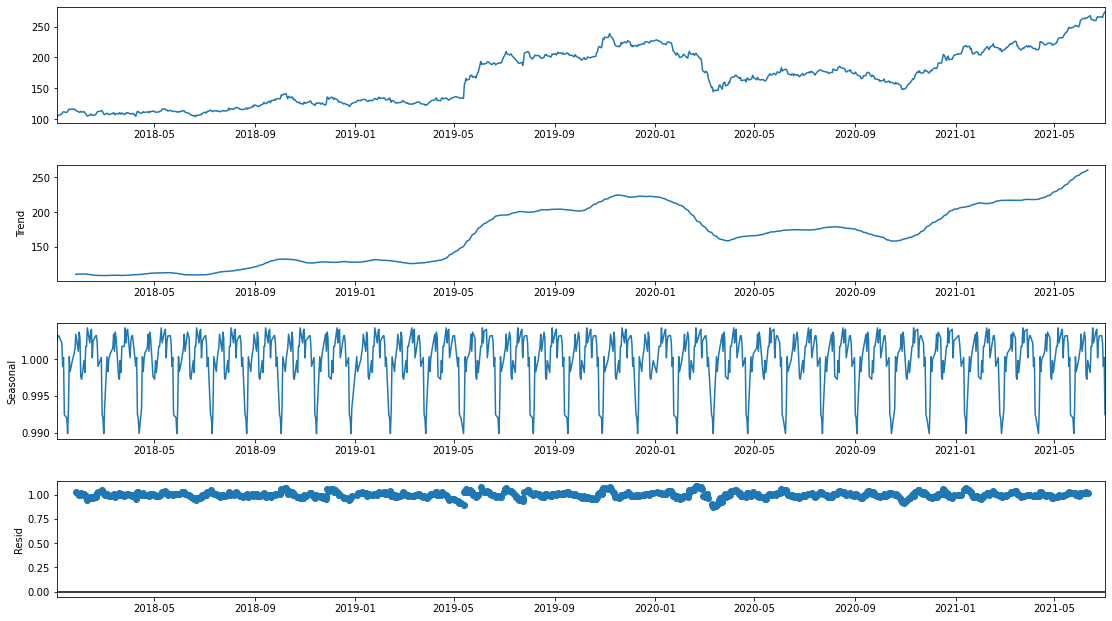

In [34]:
result = seasonal_decompose(df, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


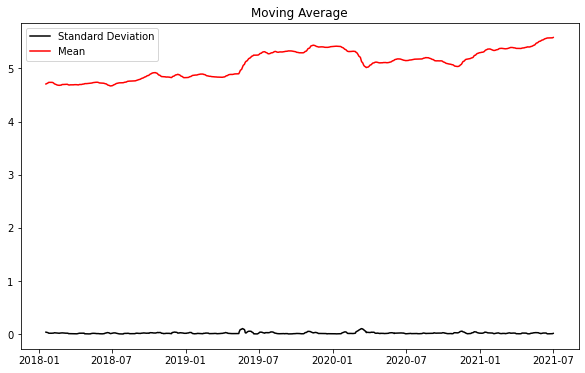

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [36]:
df_log

Date
2018-01-03    4.629742
2018-01-04    4.657272
2018-01-05    4.666283
2018-01-09    4.687069
2018-01-10    4.711273
                ...   
2021-06-28    5.582185
2021-06-29    5.577090
2021-06-30    5.595395
2021-07-01    5.605023
2021-07-02    5.611378
Name: close, Length: 877, dtype: float64

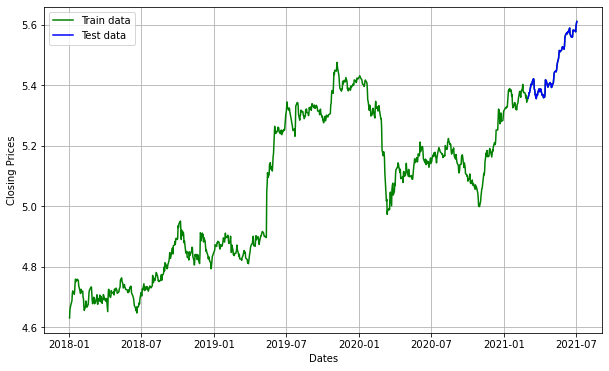

In [37]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [38]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=30, max_q=30, # maximum p and q
    m=2,              # frequency of series
    d=2,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=30,
    start_Q=0,
    max_Q=30,
    D=2, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3655.766, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3861.917, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3657.761, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-3954.644, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-4014.161, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-4045.877, Time=0.15 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-4048.707, Time=0.25 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=-4067.868, Time=0.37 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=-4072.739, Time=0.36 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=-4084.223, Time=0.32 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=-4084.053, Time=0.86 sec
 ARIMA(8,2,1)(0,0,0)[0] intercept   : AIC=-4095.390, Time=2.37 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=-4091.393, Time=1.86 sec
 ARIMA(9,2,1)(0,0,0)[0] i

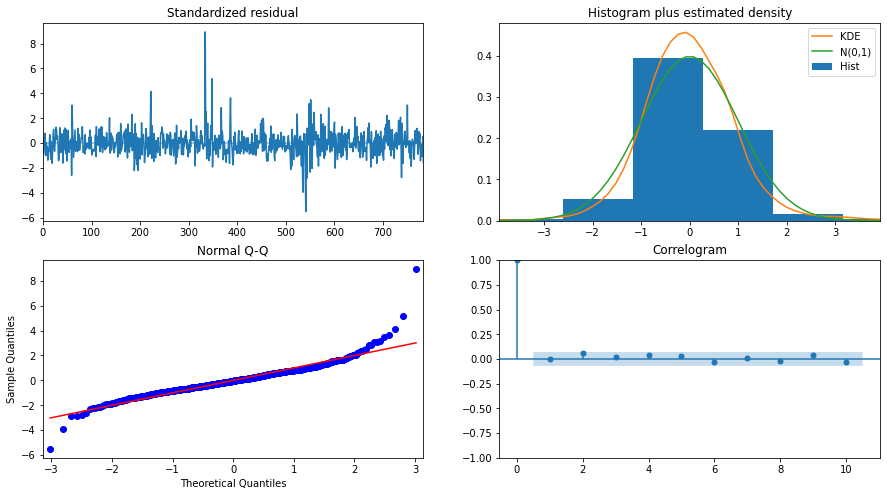

In [39]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [40]:
model = ARIMA(train_data, order=(3, 2, 4))
fitted = model.fit(disp=-1)
print(fitted.summary())

C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                  784
Model:                 ARIMA(3, 2, 4)   Log Likelihood                2079.539
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 31 May 2022   AIC                          -4141.078
Time:                        13:41:22   BIC                          -4099.099
Sample:                             2   HQIC                         -4124.936
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.617e-07   2.71e-06     -0.244      0.807   -5.98e-06    4.65e-06
ar.L1.D2.close    -0.7041        nan        nan        nan         nan         nan
ar.L2.D2.close    -0.4387        nan

In [41]:
fc, se, conf = fitted.forecast(88, alpha=0.05)  # 95% confidence

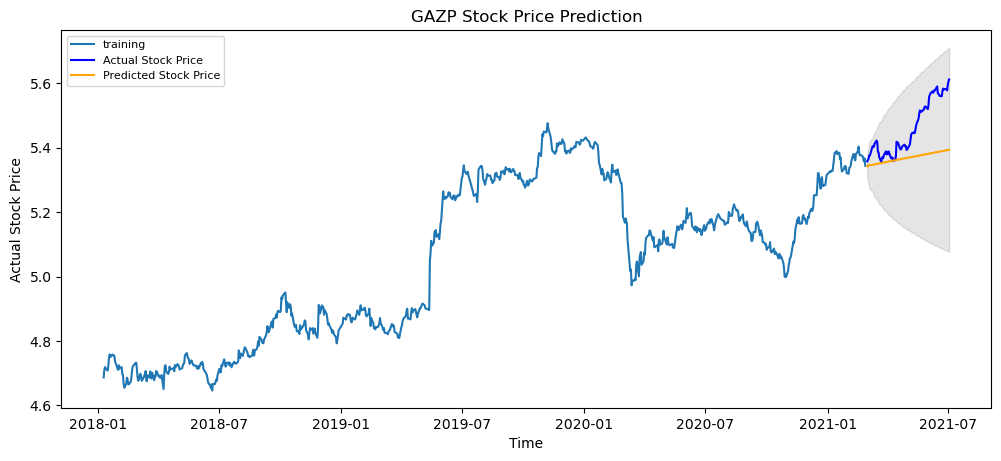

In [43]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('GAZP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [55]:
from dateutil.relativedelta import relativedelta
date_list = [datetime.datetime.strptime("2020-12-31", "%Y-%m-%d") + 
             relativedelta(days=x) for x in range(0,210)]


In [56]:
future = pd.DataFrame(index=date_list, columns= df.columns)
df2 = pd.concat([df, future])

In [57]:
df.shape

(1110, 1)

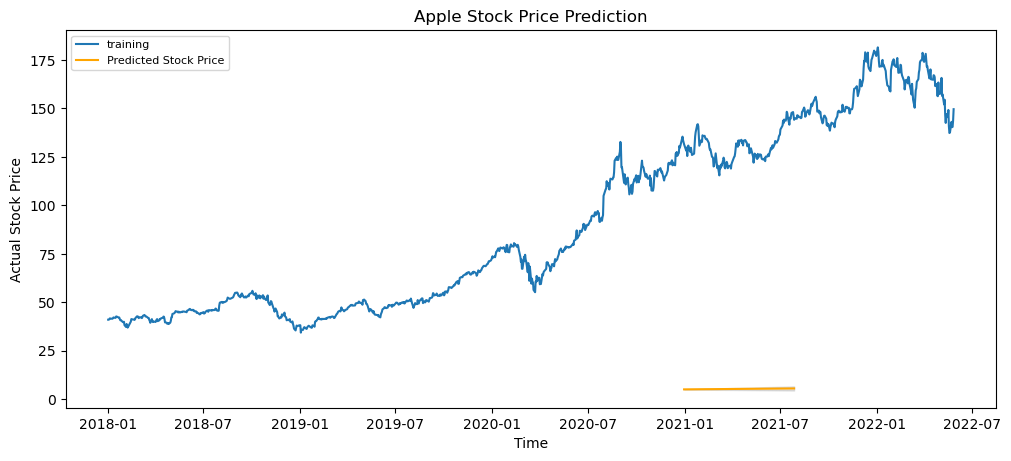

In [58]:
fc, se, conf = fitted.forecast(210, alpha=0.05)  # 95% confidence

fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='training')
#plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [59]:
model_autoARIMA = auto_arima(df, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=10, max_q=10, # maximum p and q
                 # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=10,
    start_Q=0,
    max_Q=10,
    D=2, trend='ct',
    enforce_stationarity=True,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4712.068, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4708.560, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4708.468, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4712.068, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4710.325, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4710.443, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4712.461, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4708.468, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.538 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1110
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2350.234
Date:                Mon, 30 May 2022   AIC                           4708.468
Time:                        16:44:1

In [23]:
model = ARIMA(df, order=(0, 1, 0))
fitted = model.fit(disp=1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  754
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1119.463
Method:                           css   S.D. of innovations              1.068
Date:                Mon, 30 Aug 2021   AIC                           2242.926
Time:                        12:21:25   BIC                           2252.177
Sample:                             1   HQIC                          2246.489
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0476      0.039      1.223      0.221      -0.029       0.124


C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [24]:
fc, se, conf = fitted.forecast(210, alpha=0.05)  # 95% confidence

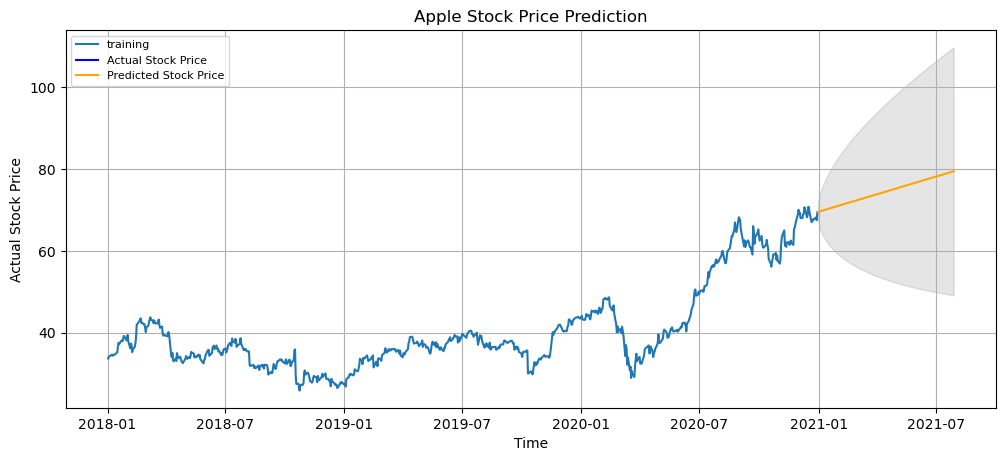

In [25]:
fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.grid(True)
plt.plot(df, label='training')
plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
print('from {} to {}, predicted {}'.format(lower_series[-1], upper_series[-1], fc_series[-1]))

from 49.15441605993337 to 109.82065059304838, predicted 79.48753332649088


In [27]:
fc_series

2020-12-31    69.547560
2021-01-01    69.595119
2021-01-02    69.642679
2021-01-03    69.690239
2021-01-04    69.737798
                ...    
2021-07-24    79.297295
2021-07-25    79.344854
2021-07-26    79.392414
2021-07-27    79.439974
2021-07-28    79.487533
Length: 210, dtype: float64

In [28]:
data2 = yf.download(ticker,'2020-12-31','2021-07-30')
data2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-30,67.620003,69.680000,67.529999,69.500000,69.500000,1202600
2020-12-31,69.449997,69.750000,68.750000,69.580002,69.580002,891800
2021-01-04,70.839996,71.169998,68.699997,69.750000,69.750000,2120400
2021-01-05,69.559998,72.949997,69.470001,72.160004,72.160004,2217200
2021-01-06,70.599998,71.120003,69.500000,70.110001,70.110001,2272400
...,...,...,...,...,...,...
2021-07-23,70.330002,70.510002,69.419998,70.339996,70.339996,706900
2021-07-26,70.410004,70.660004,69.599998,69.800003,69.800003,949600
2021-07-27,69.800003,69.879997,67.419998,68.209999,68.209999,2031700


In [29]:
future2=pd.DataFrame(data2['Adj Close'],index=data2.index)
future2=future2.rename(columns={"Adj Close":"close"})
future2

,close
Date,
2020-12-30,69.500000
2020-12-31,69.580002
2021-01-04,69.750000
2021-01-05,72.160004
2021-01-06,70.110001
...,...
2021-07-23,70.339996
2021-07-26,69.800003
2021-07-27,68.209999


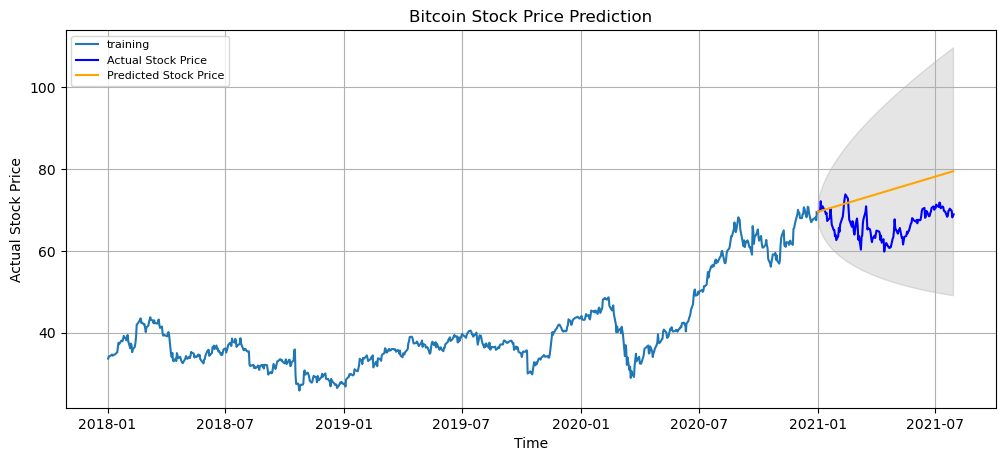

In [30]:
fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.grid(True)
plt.plot(df, label='training')
plt.plot(future2, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
fc_series

2020-12-31    69.547560
2021-01-01    69.595119
2021-01-02    69.642679
2021-01-03    69.690239
2021-01-04    69.737798
                ...    
2021-07-24    79.297295
2021-07-25    79.344854
2021-07-26    79.392414
2021-07-27    79.439974
2021-07-28    79.487533
Length: 210, dtype: float64